In [25]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.saving import save_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [26]:
df = pd.read_csv('model_data.csv')
df.head()

,Unnamed: 0.49,Unnamed: 0,trade_id,product_id,price,size,time,side,exchange,bid,...,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,141253,60305,590641283,ETH-USD,3598.16,0.013755,2025-01-04 06:38:20.767435+00:00,SELL,NaN,NaN,...,36308.0,36308.0,36308.0,36308.0,36308.0,36308.0,227275.0,227275.0,143784.0,60293.0
1,141254,60304,590641310,ETH-USD,3598.95,0.002479,2025-01-04 06:38:35.543964+00:00,SELL,NaN,NaN,...,36309.0,36309.0,36309.0,36309.0,36309.0,36309.0,227274.0,227274.0,143783.0,60292.0
2,141255,60303,590641344,ETH-USD,3598.15,3.565571,2025-01-04 06:38:55.779501+00:00,BUY,NaN,NaN,...,36310.0,36310.0,36310.0,36310.0,36310.0,36310.0,227273.0,227273.0,143782.0,60291.0
3,141256,60302,590641361,ETH-USD,3597.71,0.000987,2025-01-04 06:39:14.353069+00:00,BUY,NaN,NaN,...,36311.0,36311.0,36311.0,36311.0,36311.0,36311.0,227272.0,227272.0,143781.0,60290.0
4,141257,60301,590641382,ETH-USD,3597.72,0.200000,2025-01-04 06:39:29.902680+00:00,SELL,NaN,NaN,...,36312.0,36312.0,36312.0,36312.0,36312.0,36312.0,227271.0,227271.0,143780.0,60289.0


In [27]:
#drop unneeded columns
columns_to_drop = ['Unnamed: 0', 'exchange', 'bid', 'ask', 'trades', 'best_bid', 'best_ask', 'trade_id', 'product_id', 'side']

# Check for existing columns before dropping to avoid KeyErrors
df_trades = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

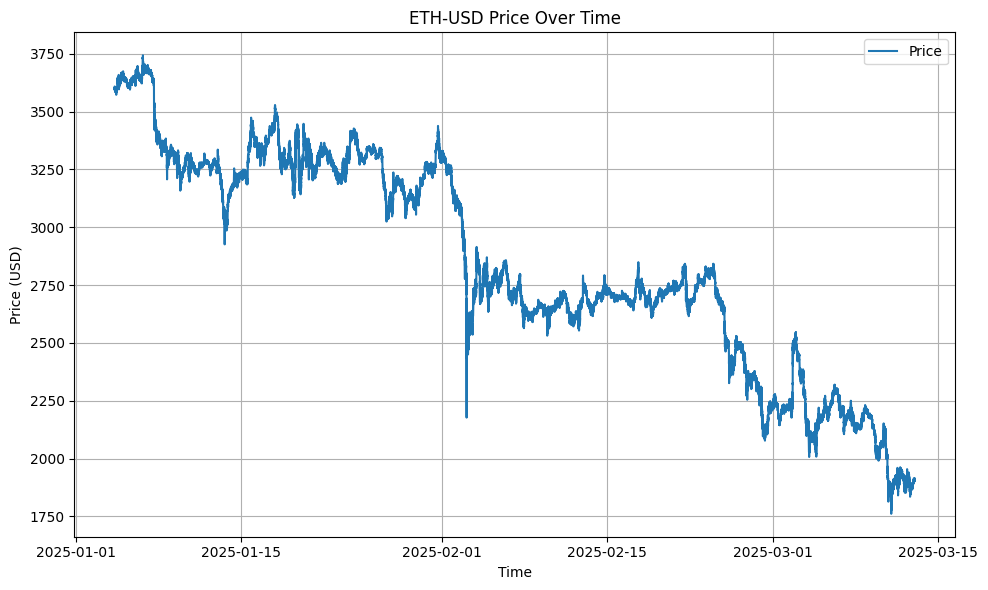

In [28]:
# Convert 'time' to datetime, coercing errors
df_trades['time'] = pd.to_datetime(df_trades['time'], errors='coerce')

# Drop rows where 'time' is NaT (invalid date)
df_trades = df_trades.dropna(subset=['time'])

# Convert 'price' column to numeric
df_trades['price'] = pd.to_numeric(df_trades['price'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_trades['time'], df_trades['price'], linestyle='-', label='Price')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('ETH-USD Price Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
# Ensure time column is sorted
df_trades = df_trades.sort_values('time')

# Scale the 'price' and 'size' column
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = RobustScaler()
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])

# Create sequences of data for LSTM
sequence_length = 10  # Sequence of 10 observations
forecast_steps = 5  # Predict 5 steps into the future

In [30]:
# Compute percent difference
df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage

# Drop the first row since pct_change for first row is NaN
df_trades = df_trades.dropna(subset=['pct_change']).reset_index(drop=True)

df_trades = df_trades.drop(columns=[col for col in df_trades.columns if col.startswith("Unnamed")])

In [31]:
df_trades['sma_5'] = df_trades['price_scaled'].rolling(window=5).mean()
df_trades['momentum'] = df_trades['price_scaled'] - df_trades['price_scaled'].shift(5)
df_trades.dropna(subset=['sma_5', 'momentum'], inplace=True)
df_trades.head()

,price,size,time,price_scaled,pct_change,sma_5,momentum
5,3597.69,0.003707,2025-01-04 06:40:00.442719+00:00,0.926538,-0.000556,0.926592,-0.000636
6,3597.70,0.006879,2025-01-04 06:40:17.994423+00:00,0.926544,0.000278,0.926547,-0.000227
7,3597.70,0.015755,2025-01-04 06:40:32.624359+00:00,0.926544,0.000000,0.926546,-0.000005
8,3597.70,0.000804,2025-01-04 06:40:48.741554+00:00,0.926544,0.000000,0.926544,-0.000010
9,3597.70,0.119900,2025-01-04 06:41:04.481562+00:00,0.926544,0.000000,0.926543,-0.000005


In [32]:
# split data into sequences and X and y
X = []
y = []

prices = df_trades['price_scaled'].values
sma_5 = df_trades['sma_5'].values
momentum = df_trades['momentum'].values
pct_change = df_trades['pct_change'].values

for i in range(len(prices) - sequence_length - forecast_steps):
    #build feature set
    #row = []
    #row.append(prices[i:i + sequence_length])
    #row.append(sma_5[i:i + sequence_length])
    #row.append(momentum[i:i + sequence_length])

    X.append(prices[i:i + sequence_length])
    #X.append(row)
    y.append(prices [i + sequence_length + forecast_steps - 1])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [33]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
X_train.shape

(1055076, 10, 1)

In [35]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - loss: 0.0037 - val_loss: 3.9344e-05
Epoch 2/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 134s 4ms/step - loss: 2.4680e-06 - val_loss: 2.7921e-05
Epoch 3/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step - loss: 2.2590e-06 - val_loss: 1.9889e-05
Epoch 4/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 192s 6ms/step - loss: 2.1703e-06 - val_loss: 1.5737e-05
Epoch 5/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 938s 28ms/step - loss: 2.0152e-06 - val_loss: 1.0455e-05
Epoch 6/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 1.9595e-06 - val_loss: 8.9329e-06
Epoch 7/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - loss: 1.8577e-06 - val_loss: 8.2607e-06
Epoch 8/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - loss: 1.7787e-06 - val_loss: 5.3399e-06
Epoch 9/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step - loss: 1.7043e-06 - val_loss: 3.9356e-06
Epoch 10/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 147s 4ms/step - loss: 1.6568e-06 - val_loss: 3.9

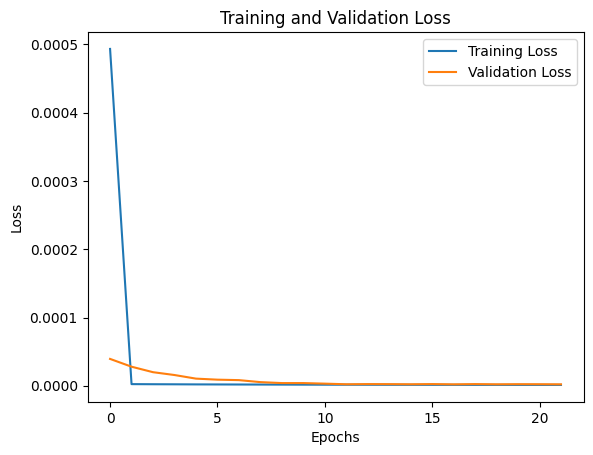

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
#save model to h5 format because mac M1 is silly
#model.save("models/model.h5", save_format='h5')
#save model to convert to ONNX model later
save_model(model=model, filepath="models/model.keras")

In [39]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and test labels to get original prices
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

8243/8243 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [40]:
model.get_metrics_result()

{'loss': 2.115861207130365e-06}

In [41]:
predictions_scaled[1]

array([0.4611113], dtype=float32)

In [42]:
y_test[10]

0.4610517711996529

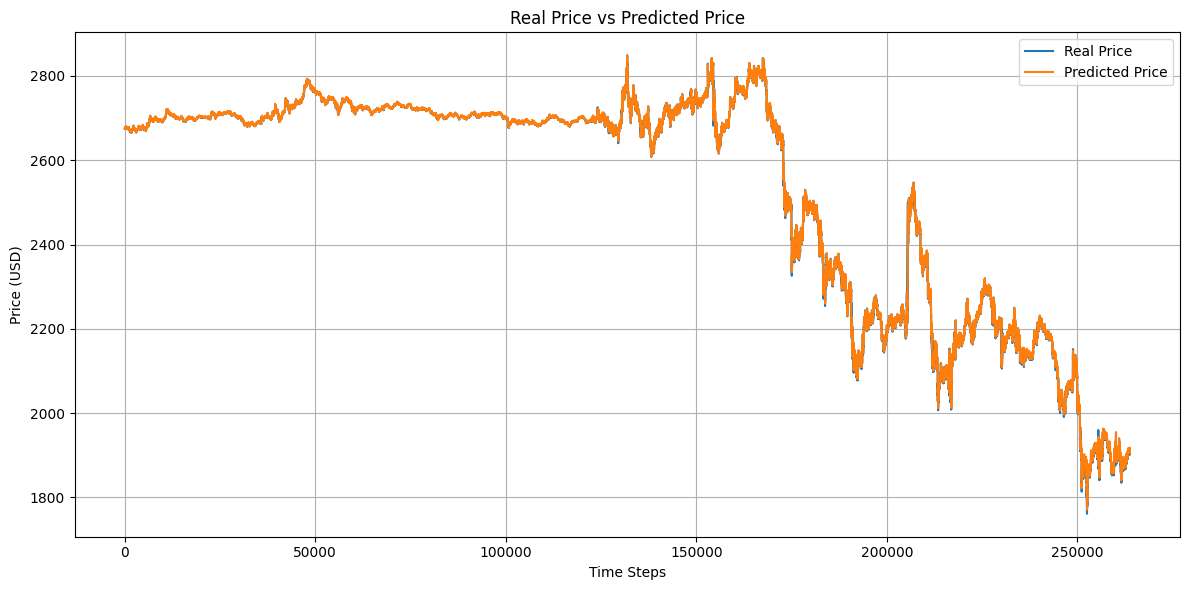

In [43]:
# Plot the real vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Real Price", linestyle='-')
plt.plot(predictions, label="Predicted Price", linestyle='-')
plt.title("Real Price vs Predicted Price")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()